In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import knn_graph, EdgeConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class RechitGNN(torch.nn.Module):
    def __init__(self, k=16):
        super().__init__()
        self.k = k

        # Step 1: Per-rechit encoder (shared across rechits)
        self.encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )

        # Step 2-4: EdgeConv + Pool (repeat 3 times)
        self.edge_conv1 = EdgeConv(MLP(2 * 128, 128))
        self.edge_conv2 = EdgeConv(MLP(2 * 128, 128))
        self.edge_conv3 = EdgeConv(MLP(2 * 128, 128))

        # Output block
        self.output_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Regression output
        )

    def forward(self, data: Batch):
        x, pos, batch = data.x, data.pos, data.batch

        # Encode input (x, y, z, E)
        x = self.encoder(x)

        # Repeated EdgeConv + KNN graph building
        for edge_conv in [self.edge_conv1, self.edge_conv2, self.edge_conv3]:
            edge_index = knn_graph(x, k=self.k, batch=batch)
            x = edge_conv(x, edge_index)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Final MLP
        out = self.output_mlp(x)
        return out.view(-1)



In [4]:
model = RechitGNN()

In [5]:
print(model)

RechitGNN(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  )
  (edge_conv1): EdgeConv(nn=MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  ))
  (edge_conv2): EdgeConv(nn=MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  ))
  (edge_conv3): EdgeConv(nn=MLP(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  ))
  (output_mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [6]:
import pickle as pk

In [7]:
with open('events.pkl', 'rb') as f:
    data = pk.load(f)

In [8]:
data

<Array [{x: [-1.94, ...], y: [...], ...}, ...] type='648277 * {x: var * flo...'>

In [10]:
import h5py
with h5py.File("hgcal_electron_data_0001.h5", "r") as f:
    target_energy = f["target"][:]  # shape: (num_events,)

In [13]:
target_energy

array([286.60653027, 260.23076694, 122.32089501, ..., 332.82049715,
       185.57844533, 179.74502153])

In [14]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class RechitEventDataset(Dataset):
    def __init__(self, events, target_energy):
        assert len(events) == len(target_energy)
        self.events = events
        self.targets = target_energy

    def __len__(self):
        return len(self.events)

    def __getitem__(self, idx):
        e = self.events[idx]
        y = self.targets[idx]

        x = torch.tensor(e['x'], dtype=torch.float32)
        y_ = torch.tensor(e['y'], dtype=torch.float32)
        z = torch.tensor(e['z'], dtype=torch.float32)
        E = torch.tensor(e['E'], dtype=torch.float32)

        features = torch.stack([x, y_, z, E], dim=-1)
        pos = features[:, :3]
        y_target = torch.tensor([y], dtype=torch.float32)

        return Data(x=features, pos=pos, y=y_target)


In [16]:
dataset = RechitEventDataset(data, target_energy)
from torch_geometric.loader import DataLoader
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [17]:
# model = RechitGNN(k=12)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# Training loop
for epoch in range(1, 101):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to("cuda" if torch.cuda.is_available() else "cpu")

        optimizer.zero_grad()
        out = model(batch)            # shape: (batch_size,)
        loss = loss_fn(out, batch.y)  # batch.y shape: (batch_size, 1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    print(f"Epoch {epoch}, Loss: {total_loss / len(dataset):.4f}")

RuntimeError: Not compiled with CUDA support

In [2]:
model = HybridGNN(input_dim=1, latent_dim=32)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 9121
Trainable parameters: 9121


In [ ]:
# ------------------------
# Dataset & Dataloader
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Temporary encoder for graph building
encoder_for_graph = FCNN_Encoder(1, latent_dim=32)
train_graphs = create_graph_dataset_batched(X_train, y_train, encoder_for_graph)
val_graphs   = create_graph_dataset_batched(X_val,   y_val,   encoder_for_graph)
test_graphs  = create_graph_dataset_batched(X_test,  y_test,  encoder_for_graph)

train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_graphs, batch_size=64)
test_loader  = DataLoader(test_graphs, batch_size=64)

# ------------------------
# Training
# ------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridGNN(input_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)               # shape [batch_size]
        target = batch.y.view(-1)         # shape [batch_size]
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Train Loss = {total_loss / len(train_loader.dataset):.4f}")

# ------------------------
# Evaluation
# ------------------------
model.eval()
all_preds, all_truth = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch).cpu().numpy()
        truth = batch.y.view(-1).cpu().numpy()
        all_preds.extend(pred)
        all_truth.extend(truth)

from sklearn.metrics import mean_squared_error, r2_score
print("\nTest MSE:", mean_squared_error(all_truth, all_preds))
print("Test R²: ", r2_score(all_truth, all_preds))


(0.5, 1.5)

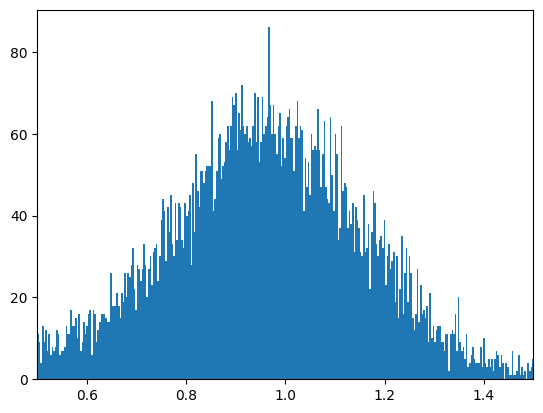

In [13]:
import matplotlib.pyplot as plt
plt.hist(np.array(all_truth)/np.array(all_preds), bins = 1000)
plt.xlim(0.5, 1.5)

In [ ]:
# Convert dataset into graphs
def create_graph_dataset(X, y, encoder, k=8):
    encoder.eval()
    with torch.no_grad():
        latent = encoder(torch.tensor(X, dtype=torch.float32))
        edge_index = build_knn_graph(latent.numpy(), k=k)

    # # Use whole batch as one big graph (can extend to per-event)
    # data = Data(
    #     x=torch.tensor(X, dtype=torch.float32),
    #     edge_index=edge_index,
    #     y=torch.tensor(y, dtype=torch.float32).view(-1, 1)
    # )

    data = Data(
    x=torch.tensor(X, dtype=torch.float32),        # shape (84, 1)
    edge_index=edge_index,
    y=torch.tensor([y[i]], dtype=torch.float32)           # shape (1,)
)

    data.batch = torch.arange(len(y))  # fake batch, 1 node = 1 batch index
    return [data]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Step 1: Initialize encoder and pre-encode features
encoder = FCNN_Encoder(X_all.shape[1], latent_dim=32)
with torch.no_grad():
    encoder_output = encoder(torch.tensor(X_train, dtype=torch.float32))

# Step 2: Build graph
train_data_list = create_graph_dataset(X_train, y_train, encoder, k=8)
test_data_list  = create_graph_dataset(X_test,  y_test,  encoder, k=8)

train_loader = DataLoader(train_data_list, batch_size=1)
test_loader  = DataLoader(test_data_list, batch_size=1)

# Step 3: Train full model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridGNN(X_all.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_fn(pred.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Train Loss = {total_loss:.4f}")

# Evaluation
model.eval()
all_preds, all_truth = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch).view(-1)
        all_preds.extend(pred.cpu().numpy())
        all_truth.extend(batch.y.view(-1).cpu().numpy())

from sklearn.metrics import mean_squared_error, r2_score
print("Test MSE:", mean_squared_error(all_truth, all_preds))
print("Test R²: ", r2_score(all_truth, all_preds))


/home/bapi_cms/miniconda3/envs/temporary/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/bapi_cms/miniconda3/envs/temporary/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40000])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch   0: Train Loss = 39536.1133
Epoch  10: Train Loss = 39382.0195
Epoch  20: Train Loss = 38707.1406
Epoch  30: Train Loss = 35977.7227
Epoch  40: Train Loss = 26866.4609
Epoch  50: Train Loss = 10325.7363
Epoch  60: Train Loss = 10725.2100
Epoch  70: Train Loss = 9931.2910
Epoch  80: Train Loss = 9372.9033
Epoch  90: Train Loss = 9433.2793


ValueError: Found input variables with inconsistent numbers of samples: [10000, 1]

In [2]:
test_pred.shape

(10000,)

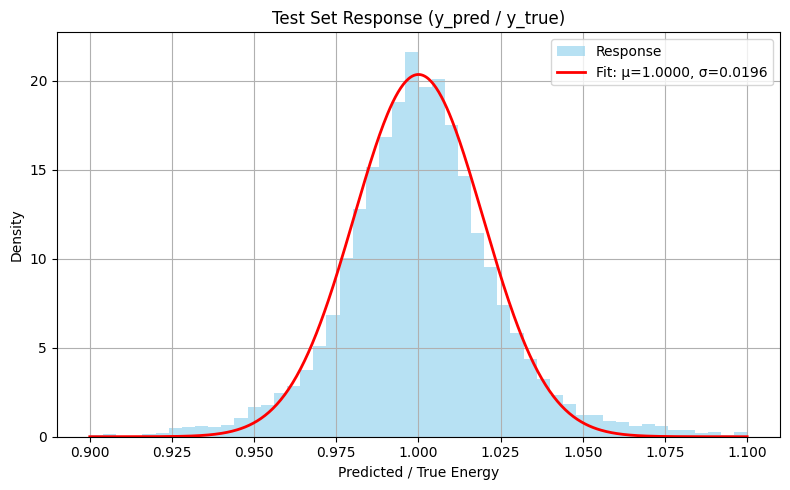

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.optimize import curve_fit

# --------------------------------------------------------
# Compute response = prediction / target on the test set
# --------------------------------------------------------
response = test_pred / test_true

# Truncate to [0.9, 1.1] for fitting and plotting
mask = (response >= 0.9) & (response <= 1.1)
response_cut = response[mask]

# --------------------------------------------------------
# Fit truncated Gaussian: scipy's PDF for fitting
# --------------------------------------------------------
def truncated_gaussian(x, mu, sigma, a=0.9, b=1.1):
    a_, b_ = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.pdf(x, a_, b_, loc=mu, scale=sigma)

# Histogram the data for fitting
hist_vals, bin_edges = np.histogram(response_cut, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Initial guess for mu and sigma
mu0, sigma0 = np.mean(response_cut), np.std(response_cut)

# Fit
popt, _ = curve_fit(truncated_gaussian, bin_centers, hist_vals, p0=[mu0, sigma0])

# --------------------------------------------------------
# Plot response histogram and fitted truncated Gaussian
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(response_cut, bins=50, range=(0.9, 1.1), density=True, alpha=0.6, color='skyblue', label='Response')

x_vals = np.linspace(0.9, 1.1, 500)
plt.plot(x_vals, truncated_gaussian(x_vals, *popt), 'r-', lw=2, label=f'Fit: μ={popt[0]:.4f}, σ={popt[1]:.4f}')

plt.xlabel("Predicted / True Energy")
plt.ylabel("Density")
plt.title("Test Set Response (y_pred / y_true)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
